# Simulating Mercury Intrusion Porosimetry Curves

Mercury intrusion is a common technique in the study of porous media used to determine the pore size distribution of a porous material. In this example, we will show how OpenPNM can be used to simulate mercury intrusion and estimate the pore size distribution of a network.

In [1]:
import numpy as np
import openpnm as op
import matplotlib.pyplot as plt

op.visualization.set_mpl_style()
np.random.seed(10)
ws = op.Workspace()
ws.settings["loglevel"] = 40
np.set_printoptions(precision=5)

## Network

In this example we use a simple cubic network with 20 pores per side and a spacing of 50 um.

In [2]:
net = op.network.Cubic(shape=[20, 20, 20], spacing=5e-5)

## Add Geometry

The network object only contains topological and spatial information.  We need to assign some pore and throat sizes, which can be conveniently done using the `spheres_and_cylinders` collection of geometry models. The collection is added to the network. Don't forget to regenerate models on the network object after adding the geometry models!

In [3]:
geo = op.models.collections.geometry.spheres_and_cylinders
net.add_model_collection(geo)
net.regenerate_models()

The `spheres_and_cylinders` geometry collection includes pore and throat diameter models. The model for pore diameter assigns pores as random values between 0.2 and 0.7 of the lattice spacing. Throat diameter is determined as half of the smallest neighbour pore. All geometric information in this model collection assumes the pores are spheres and the throats are cylinders.

## Phase

Next we create a phase object which contains the thermophysical properties of the invading fluid, such as surface tension. In the case of mercury intrusion, the invading fluid is of course mercury!

In [4]:
hg = op.phase.Mercury(network=net, name='mercury')

## Add Physics

To simulate mercury intrusion, we will need to calulate the capillary pressure of the throats in the network. The capillary pressure can be calculated using the Washburn equation as provided below.

$$ P_C = \frac{-2\sigma cos(\theta)}{R_T} $$

The `basic` collection of physics model already contains the washburn model for capillary pressure so we will add it to the mercury phase object.

In [5]:
phys = op.models.collections.physics.basic
hg.add_model_collection(phys)
hg.regenerate_models()

------------------------------------------------------------
  - WARNING: throat.diffusive_conductance was not run since the following property is missing: 'throat.diffusivity' 
  - SOURCE : openpnm.core._models.regenerate_models 
  - TIME   : 2022-09-20 13:21:45,993    
------------------------------------------------------------


The washburn model will fetch the surface tension and contact angle from the mercury phase object while the throat radius is fetched from the network object. 

## Perform Mercury Intrusion

Now that all the required objects and models are setup, we can perform the capillary pressure curve simulation.  OpenPNM contains both InvasionPercolation and OrdinaryPercolation classes. The porosimetry experiment is ordinary percolation with access limitations. This means that a fixed pressure is applied to the invading fluid and all pores and throats that can be penetrated at that pressure are set as *possibly* invaded, *then* pores and throats are set to invaded only if they are physically connected to the source of invading fluid directly or though a path of already invading pores and throats.  

**FIX: Where is porosimetry class? Since this process is simulated very frequently, OpenPNM includes a class called Porosimetry that is a subclass of OrdinaryPercolation, with several useful methods added. It's use is illustrated below:**

In [8]:
mip = op.algorithms.Drainage(network=net, phase=hg)
mip.set_inlet_BC(pores=net.pores('front'))
mip.run()

Performing drainage simulation: 100%|█████████████████████████████████████████████████| 25/25 [00:00<00:00, 128.02it/s]


The meaning of this warning message will be analyzed below, but first let's take a quick look at the result using the built-in plotting method:

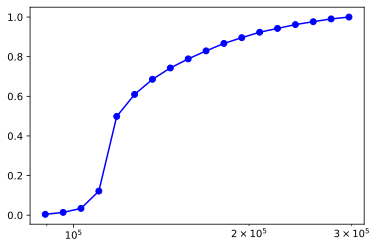

In [14]:
pc = mip.pc_curve()
plt.semilogx(*pc, 'b-o');